In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import random
from PIL import Image
from types import SimpleNamespace
from progressive_gan import Generator, Discriminator, train_fn, set_seeds
import json
from example_generator import generate_example_animation, generate_examples

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()
set_seeds()

In [3]:
config = {
    'experiment_name'         : "fine_tune_23_with_giga_dataset",
    'dataset'                 : "all_assets_and_bulbapedia", #2D_assets, all_assets, bulbapedia or all_assets_and_bulbapedia ###needs to have a subfolder(s) which contains the data
    'start_train_at_img_size' : 4,
    'device'                  : "cuda" if torch.cuda.is_available() else "mps",
    'learning_rate'           : 1e-3,
    'batch_sizes'             : [32, 32, 32, 16, 16, 16, 8], #[8224, 4112, 1028, 256, 64, 32, 16] #you can use [32, 32, 32, 16, 16, 16, 16, 8, 4] for example if you want to train until 1024x1024, but again this numbers depend on your vram
    'image_size'              : 128,
    'channels_img'            : 3,
    'z_dim'                   : 256,  # should be 512 in original paper
    'in_channels'             : 256,  # should be 512 in original paper
    'lambda_gp'               : 10,
    'epochs'                  : 100, #for continue these are the complete epochs incuding the already trained ones, for fine_tunining these are the extra epochs
    'save_every_n_epochs'     : 10,

    'load_model'              : True,
    'saved_path'              : "outputs/23_first_try_bulbapedia_23_bulbapedia_256x256_e50/",
    'image_size_saved'        : 128,
    'last_epoch'              : 0, #use the one saved in the file
    'fine_tune'               : True,
    'pre_epochs_offset'       : 50,
}

config = SimpleNamespace(**config)

config.progressive_epochs = [config.epochs] * len(config.batch_sizes)
#safety to disable pre_epochs_offset if fine_tune is False
if not config.fine_tune:
    config.pre_epochs_offset = 0

In [4]:
amount_folders = len([name for name in os.listdir('outputs') if os.path.isdir(os.path.join('outputs', name))])

config.experiment_name = f"{amount_folders}_{config.experiment_name}_{amount_folders}_{config.dataset}_{config.image_size}x{config.image_size}_e{config.epochs}"
print(config.experiment_name)

OUTPUT_DIR = f'outputs/{config.experiment_name}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

31_fine_tune_23_with_giga_dataset_31_all_assets_and_bulbapedia_128x128_e100


In [5]:
json.dump(config.__dict__, open(f"{OUTPUT_DIR}/config.json", 'w'))

In [6]:
def get_loader(image_size):
    batch_size = config.batch_sizes[int(log2(image_size / 4))]
    dataset = dset.ImageFolder(root=f"dataset/{config.dataset}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
    return dataloader, dataset

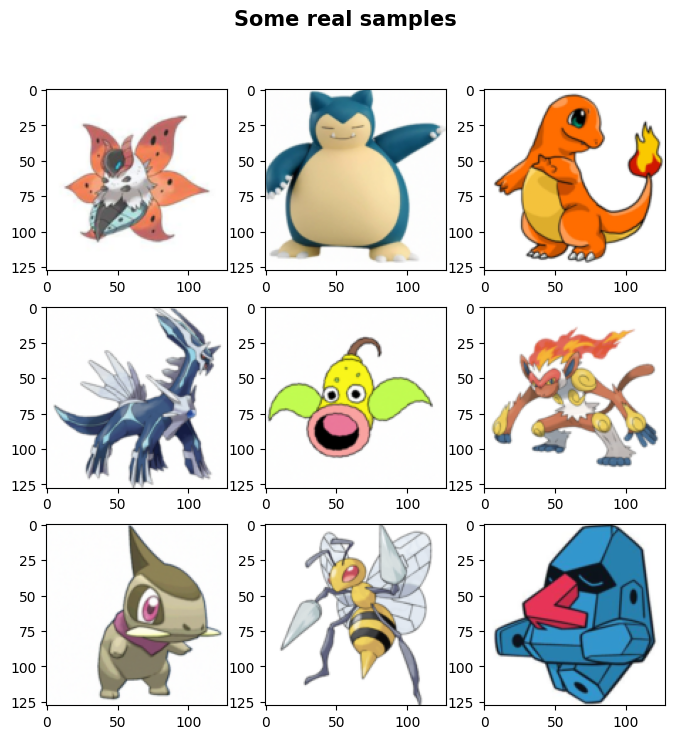

In [7]:
def check_loader():
    loader,_ = get_loader(128)
    cloth ,_ = next(iter(loader))
    _, ax    = plt.subplots(3,3, figsize=(8,8))
    plt.suptitle('Some real samples', fontsize=15, fontweight='bold')
    ind = 0 
    for k in range(3):
        for kk in range(3):
            ind += 1
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2) 
check_loader()

In [8]:
torch.backends.cudnn.benchmarks = True

In [9]:
def generate_and_save(gen, critic, step, n=100, path=OUTPUT_DIR, epoch=None):

    generate_examples(gen, step, config.z_dim, device=config.device, n=100, path=path, epoch=epoch)

    generator_name = f'{path}/generator_{4 * 2 ** step}'
    if epoch is not None:
        generator_name += f'_{epoch}'
    critic_name = f'{path}/critic_{4 * 2 ** step}'
    if epoch is not None:
        critic_name += f'_{epoch}'

    torch.save(gen.state_dict(), f'{generator_name}.pth')
    torch.save(critic.state_dict(), f'{critic_name}.pth')

In [10]:
# initialize gen and disc, note: discriminator we called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(
    config.z_dim, config.in_channels, img_channels=config.channels_img
).to(config.device)

critic = Discriminator(
    config.in_channels, img_channels=config.channels_img
).to(config.device)

if config.load_model:
    saved_model_id = f'{config.image_size_saved}'
    config.start_train_at_img_size = config.image_size_saved*2
    if config.last_epoch != 0:
        saved_model_id += f'_{config.last_epoch}'
    if config.last_epoch != 0 or config.fine_tune:
        config.start_train_at_img_size = config.image_size_saved
    gen.load_state_dict(torch.load(config.saved_path + f'generator_{saved_model_id}.pth'))
    critic.load_state_dict(torch.load(config.saved_path + f'critic_{saved_model_id}.pth'))

# initialize optimizers
opt_gen = optim.Adam(gen.parameters(), lr=config.learning_rate, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.learning_rate, betas=(0.0, 0.99)
)


gen.train()
critic.train()

os.makedirs(OUTPUT_DIR, exist_ok=True)

step = int(log2(config.start_train_at_img_size / 4))
try:
    for num_epochs in config.progressive_epochs[step:]: #reduce iteration based on start image size (required if model loaded from drive)
        alpha = 1e-5
        loader, dataset = get_loader(4 * 2 ** step) # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        epochs_range = range(num_epochs)
        if config.load_model and config.last_epoch != 0:
            epochs_range = range(config.last_epoch, num_epochs)
        for epoch in epochs_range:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                config.z_dim,
                config.lambda_gp,
                config.progressive_epochs,
                config.device
            )
            if (epoch+1) % config.save_every_n_epochs == 0 and epoch != num_epochs-1:
                generate_and_save(gen, critic, step, n=100, path=OUTPUT_DIR, epoch=epoch+1+config.pre_epochs_offset)
        
        epochs_naming = None
        if config.pre_epochs_offset:
            epochs_naming=epoch+1+config.pre_epochs_offset
        generate_and_save(gen, critic, step, n=100, path=OUTPUT_DIR, epoch=epochs_naming)

        step += 1  # Progress to the next image size
except KeyboardInterrupt:
    print("Training interrupted by user")
    interupted_folder = f'{OUTPUT_DIR}/interrupted'
    os.makedirs(interupted_folder, exist_ok=True)
    torch.save(gen.state_dict(), f'{interupted_folder}/generator_interrupted_{4 * 2 ** step}.pth')
    torch.save(critic.state_dict(), f'{interupted_folder}/critic_interrupted{4 * 2 ** step}.pth')
    print("Model state saved successfully on interruption.")
finally:
    os.makedirs(f'{OUTPUT_DIR}/interrupted', exist_ok=True)
    generate_examples(gen, step, config.z_dim, device=config.device, n=100, path=f'{OUTPUT_DIR}/interrupted') #TODO: doesn't this always execute? also with an uninterupted training?
    generate_example_animation(OUTPUT_DIR   , 256, 256, 3, fps=3, display_animation=True)
    print("Cleaning up resources...")

Current image size: 128
Epoch [1/100]


100%|██████████| 2135/2135 [14:29<00:00,  2.45it/s, gp=0.0552, loss_critic=-6.98] 


Epoch [2/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.143, loss_critic=-10.8]  


Epoch [3/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.138, loss_critic=-13]     


Epoch [4/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.0975, loss_critic=-26.8]  


Epoch [5/100]


100%|██████████| 2135/2135 [13:51<00:00,  2.57it/s, gp=0.148, loss_critic=-9.02]    


Epoch [6/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.158, loss_critic=-4.85]  


Epoch [7/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.0733, loss_critic=-11.4] 


Epoch [8/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.109, loss_critic=-13.6]  


Epoch [9/100]


100%|██████████| 2135/2135 [13:51<00:00,  2.57it/s, gp=0.092, loss_critic=-7.62]  


Epoch [10/100]


100%|██████████| 2135/2135 [13:50<00:00,  2.57it/s, gp=0.0982, loss_critic=-7.22]  


Epoch [11/100]


 20%|█▉        | 422/2135 [02:45<11:10,  2.55it/s, gp=0.107, loss_critic=-7.07] 

In [ ]:
def load_images_from_folder(folder, num_images=100):
    images = []
    for i in range(0, num_images):
        filename = os.path.join(folder, f'img_{i}.png')
        try:
            img = Image.open(filename)
            images.append(img)
        except IOError:
            print(f"Error opening {filename}")
    return images

def plot_images(images, grid_size=(10, 10)):
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(20, 20))
    axes = axes.flatten()
    
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# Load and plot images for all steps
for step in range(0, 5):
    folder_path = rf'outputs/{config.experiment_name}/step{step}'
    images = load_images_from_folder(folder_path)
    print(f"Loaded {len(images)} images from {folder_path}")
    plot_images(images)